# Scenario_01

In [ ]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/DRDO/flowers', output="output", seed=1337, ratio=(.7, .1, .2))

Copying files: 5204 files [00:19, 263.15 files/s]


In [ ]:
# Import the required libraries
import os
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fowlkes_mallows_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [ ]:
# Define data directories
train_dir ="/content/output/train"
test_dir = "/content/output/test"

# Define image dimensions and batch size
img_height = 224
img_width = 224
batch_size = 32

# Create data generators with data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift the width of images
    height_shift_range=0.2,  # Randomly shift the height of images
    horizontal_flip=True,  # Randomly flip images horizontally
    shear_range=0.2,  # Apply shear transformation
    zoom_range=0.2,  # Apply random zoom
    fill_mode='nearest'  # Fill in newly created pixels
)

# Create data generators for validation and test sets (no augmentation)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load and preprocess data using data generators
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # for multi-class classification
)

val_data = val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Optionally, you can check the class labels:
class_labels = train_data.class_indices
print(class_labels)


Found 3640 images belonging to 5 classes.
Found 1046 images belonging to 5 classes.
{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
train_data.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

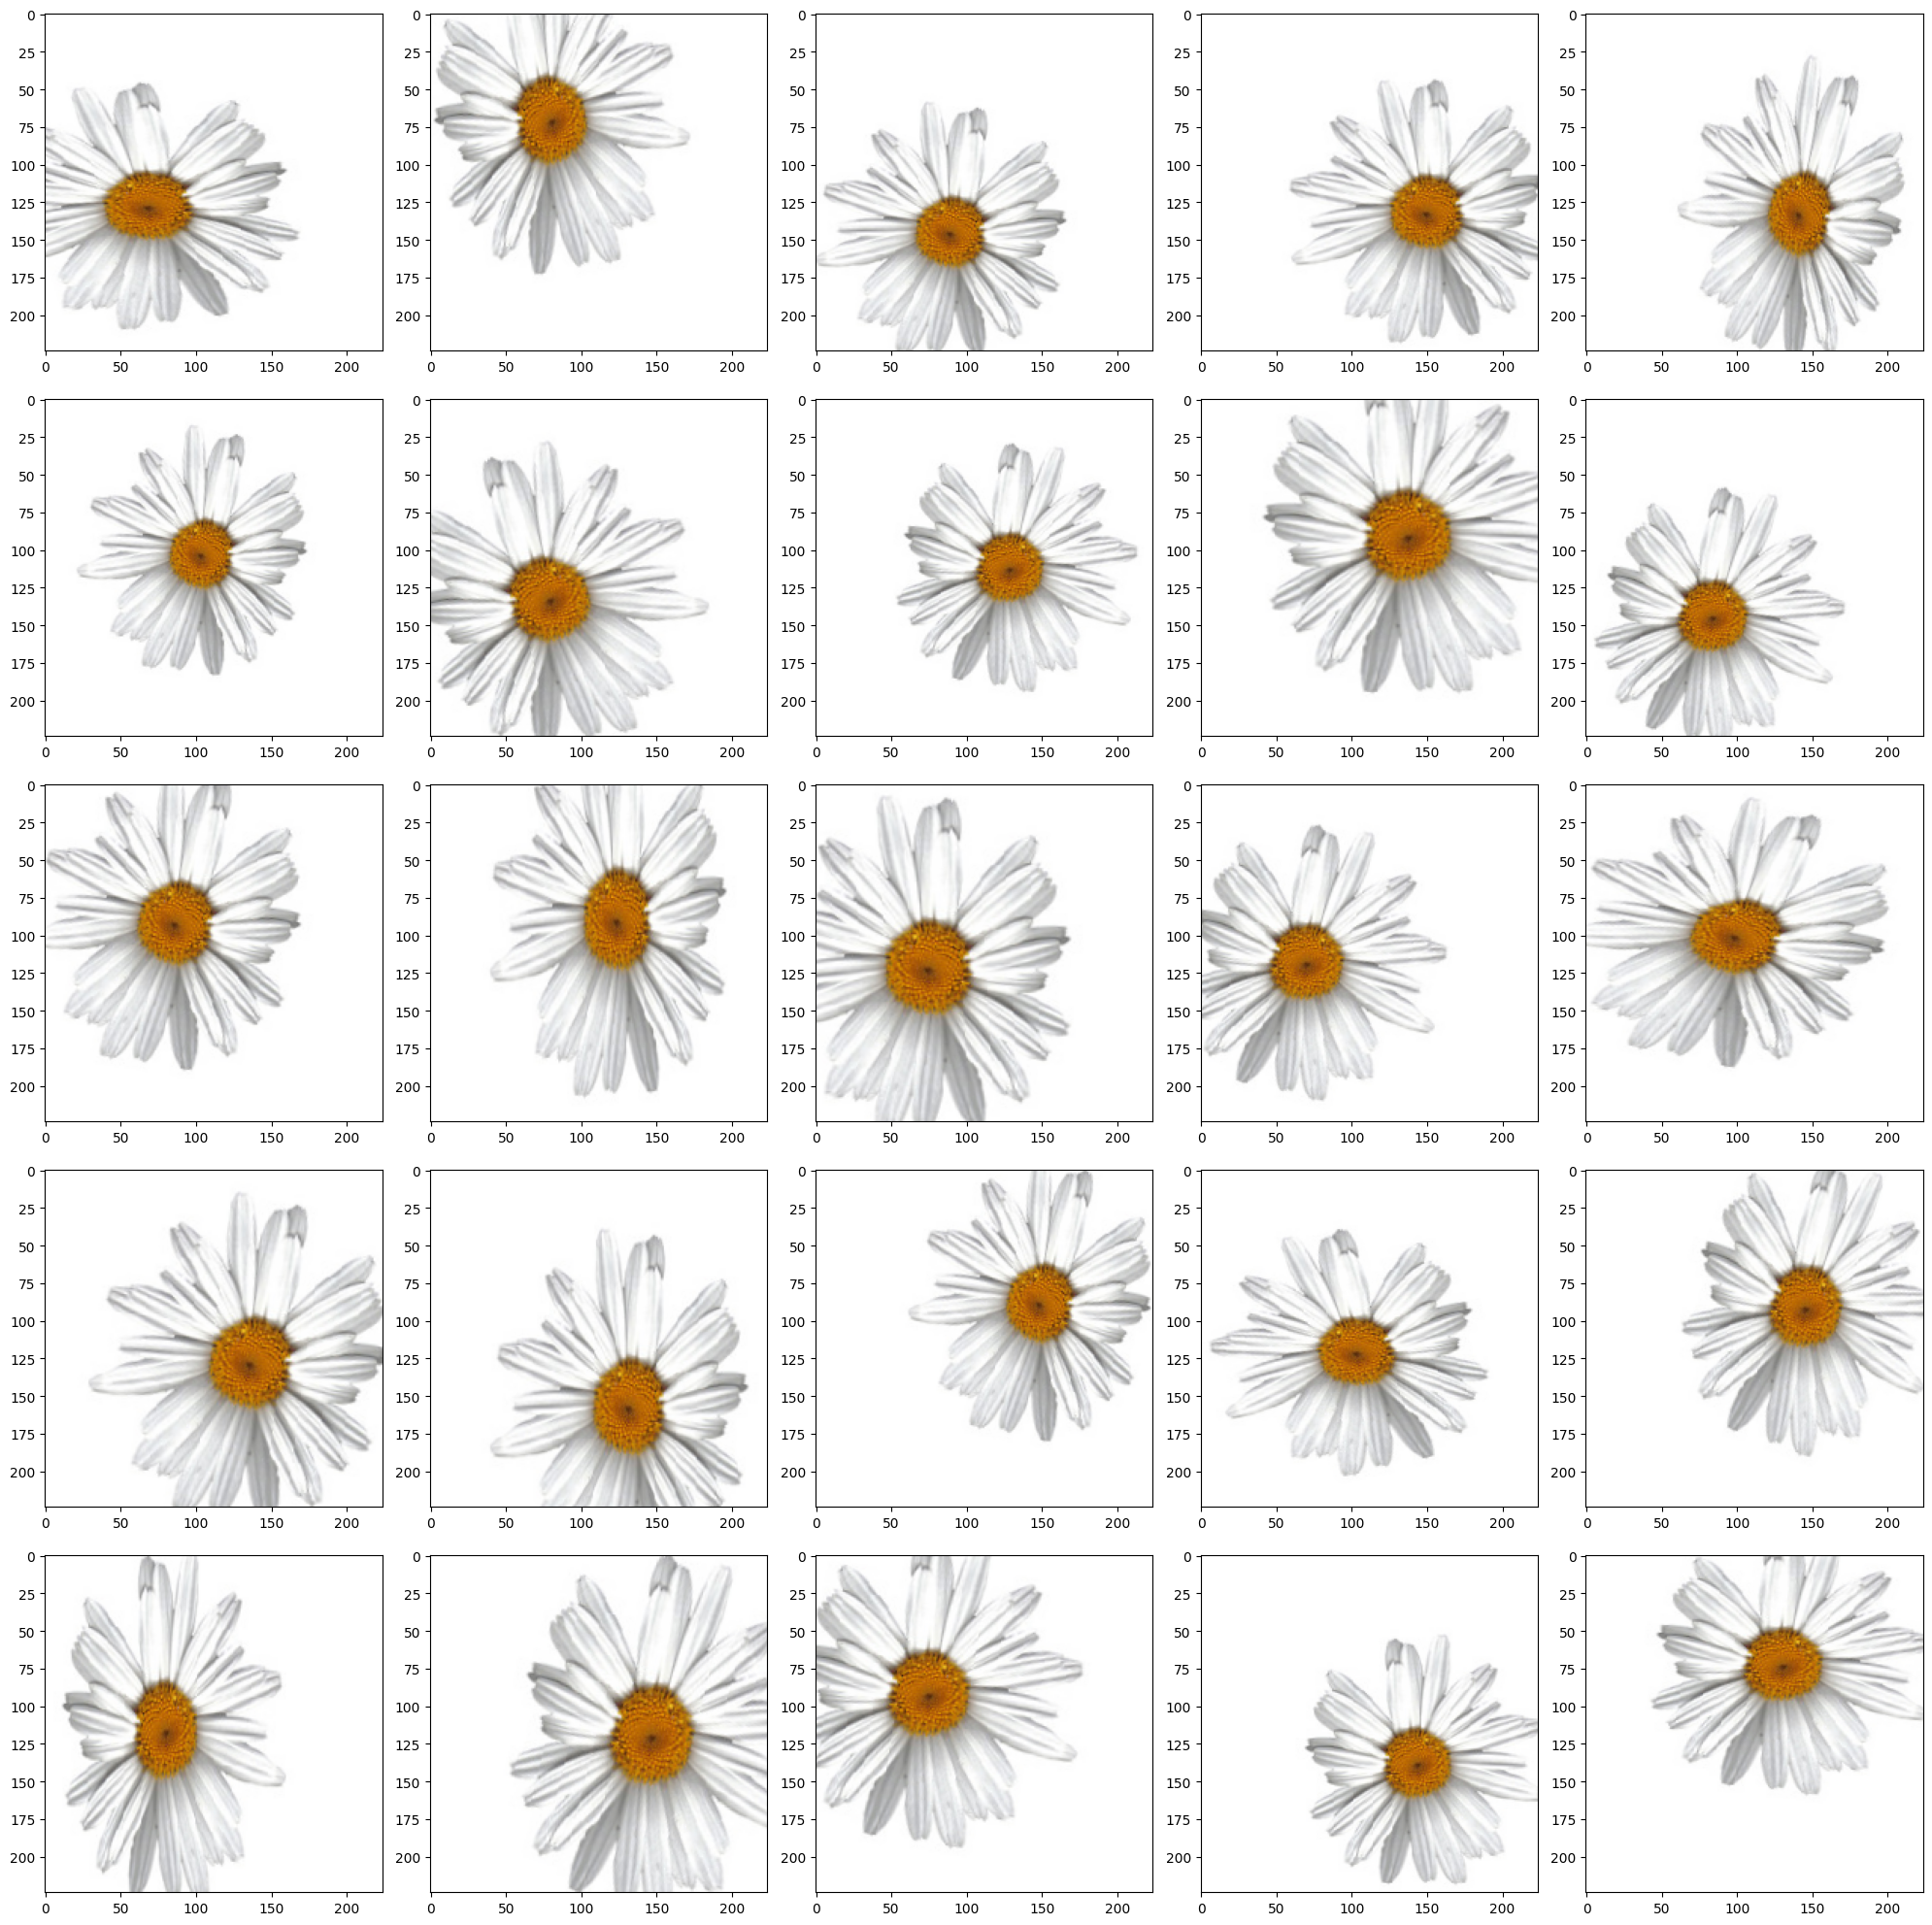

In [ ]:
images = [train_data[0][0][0] for i in range(25)]
plotImages(images)

In [ ]:
# Define the CNN model
model = models.Sequential()

# Convolutional layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional layer 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output before the fully connected layers
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(5, activation='softmax'))  # 5 classes, so 5 output neurons with softmax activation

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])   # Here we are compiling the model

In [ ]:
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/drdo_weights.h5',
    monitor='val_accuracy',  # Choose the metric you want to monitor (e.g., val_loss, val_accuracy)
    save_best_only=True,  # Save only the best model weights
    mode='max',  # 'max' for accuracy, 'min' for loss, 'auto' will automatically infer the mode
    verbose=1  # Display messages about the model saving process
)

In [ ]:
history = model.fit(
    train_data,
    epochs=1,  # Initially we will take only 1 epoch
    validation_data=val_data,
    callbacks=[checkpoint
               ]
)

In [ ]:
# Load the pretrained model from the end of epoch 1
model.load_weights('/content/flower_best_model_weights.h5')

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training from epoch 2 for an additional 4 epochs
history = model.fit(
    train_data,
    epochs=5,  # 1 previous epoch + 4 additional epochs
    initial_epoch=1,  # Start from epoch 2
    validation_data=val_data,
    callbacks=[checkpoint]  # Include the checkpoint
)

#_________________________________________________________________________


# Load the pretrained model from the end of epoch 5
model.load_weights('/content/drive/MyDrive/drdo_weights.h5')

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training from epoch 5 for an additional 10 epochs
history = model.fit(
    train_data,
    epochs=15,  # 5 previous epochs + 10 additional epochs
    initial_epoch=5,  # Start from epoch 5
    validation_data=val_data,
    callbacks=[checkpoint]  # Include the checkpoint
)


Epoch 6/15
114/114 [==============================] - ETA: 0s - loss: 0.8655 - accuracy: 0.6728
Epoch 6: val_accuracy improved from -inf to 0.74379, saving model to /content/drive/MyDrive/drdo_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - 68s 477ms/step - loss: 0.8655 - accuracy: 0.6728 - val_loss: 0.7178 - val_accuracy: 0.7438
Epoch 7/15
114/114 [==============================] - ETA: 0s - loss: 0.8186 - accuracy: 0.6962
Epoch 7: val_accuracy did not improve from 0.74379
114/114 [==============================] - 53s 467ms/step - loss: 0.8186 - accuracy: 0.6962 - val_loss: 0.8290 - val_accuracy: 0.7027
Epoch 8/15
114/114 [==============================] - ETA: 0s - loss: 0.7999 - accuracy: 0.7052
Epoch 8: val_accuracy improved from 0.74379 to 0.74952, saving model to /content/drive/MyDrive/drdo_weights.h5
114/114 [==============================] - 55s 484ms/step - loss: 0.7999 - accuracy: 0.7052 - val_loss: 0.6791 - val_accuracy: 0.7495
Epoch 9/15
114/114 [==============================] - ETA: 0s - loss: 0.7893 - accuracy: 0.7025
Epoch 9: val_accuracy did not improve from 0.74952
114/114 [==============================] - 54s 472ms/step - loss: 0.7893 - accuracy: 0.7025 - val

In [ ]:
# Load the pretrained model from the end of epoch 15
model.load_weights('/content/drive/MyDrive/drdo_weights.h5')

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training from epoch 15 for an additional 20 epochs
history = model.fit(
    train_data,
    epochs=35,  # 15 previous epochs + 20 additional epochs
    initial_epoch=15,  # Start from epoch 5
    validation_data=val_data,
    callbacks=[checkpoint]  # Include the checkpoint
)


Epoch 16/35
114/114 [==============================] - ETA: 0s - loss: 0.7173 - accuracy: 0.7305
Epoch 16: val_accuracy improved from 0.77629 to 0.77916, saving model to /content/drive/MyDrive/drdo_weights.h5
114/114 [==============================] - 76s 634ms/step - loss: 0.7173 - accuracy: 0.7305 - val_loss: 0.5931 - val_accuracy: 0.7792
Epoch 17/35
114/114 [==============================] - ETA: 0s - loss: 0.6592 - accuracy: 0.7558
Epoch 17: val_accuracy improved from 0.77916 to 0.78298, saving model to /content/drive/MyDrive/drdo_weights.h5
114/114 [==============================] - 57s 499ms/step - loss: 0.6592 - accuracy: 0.7558 - val_loss: 0.6138 - val_accuracy: 0.7830
Epoch 18/35
114/114 [==============================] - ETA: 0s - loss: 0.6783 - accuracy: 0.7505
Epoch 18: val_accuracy did not improve from 0.78298
114/114 [==============================] - 62s 547ms/step - loss: 0.6783 - accuracy: 0.7505 - val_loss: 0.5980 - val_accuracy: 0.7792
Epoch 19/35
114/114 [==========

In [ ]:
# Load the pretrained model from the end of epoch 35
model.load_weights('/content/drive/MyDrive/drdo_weights.h5')

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training from epoch 15 for an additional 20 epochs
history = model.fit(
    train_data,
    epochs=45,  # 35 previous epochs + 10 additional epochs
    initial_epoch=35,  # Start from epoch 35
    validation_data=val_data,
    callbacks=[checkpoint]  # Include the checkpoint
)


Epoch 36/45
114/114 [==============================] - ETA: 0s - loss: 0.5466 - accuracy: 0.7989
Epoch 36: val_accuracy did not improve from 0.82314
114/114 [==============================] - 114s 566ms/step - loss: 0.5466 - accuracy: 0.7989 - val_loss: 0.5752 - val_accuracy: 0.8107
Epoch 37/45
114/114 [==============================] - ETA: 0s - loss: 0.5271 - accuracy: 0.8071
Epoch 37: val_accuracy improved from 0.82314 to 0.82409, saving model to /content/drive/MyDrive/drdo_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - 64s 564ms/step - loss: 0.5271 - accuracy: 0.8071 - val_loss: 0.5699 - val_accuracy: 0.8241
Epoch 38/45
114/114 [==============================] - ETA: 0s - loss: 0.5191 - accuracy: 0.8080
Epoch 38: val_accuracy improved from 0.82409 to 0.82600, saving model to /content/drive/MyDrive/drdo_weights.h5
114/114 [==============================] - 60s 528ms/step - loss: 0.5191 - accuracy: 0.8080 - val_loss: 0.5837 - val_accuracy: 0.8260
Epoch 39/45
114/114 [==============================] - ETA: 0s - loss: 0.5079 - accuracy: 0.8146
Epoch 39: val_accuracy did not improve from 0.82600
114/114 [==============================] - 62s 544ms/step - loss: 0.5079 - accuracy: 0.8146 - val_loss: 0.7397 - val_accuracy: 0.7906
Epoch 40/45
114/114 [==============================] - ETA: 0s - loss: 0.5165 - accuracy: 0.8121
Epoch 40: val_accuracy did not improve from 0.82600
114/114 [==============================] - 59s 520ms/step - loss: 0.5165 - accuracy: 0.8121

In [ ]:
history.history

{'loss': [0.7173010110855103,
  0.659170389175415,
  0.6783056855201721,
  0.6669718623161316,
  0.6543869376182556,
  0.6641696095466614,
  0.6404986381530762,
  0.5991408228874207,
  0.6323217153549194,
  0.5933075547218323,
  0.6270056366920471,
  0.5705668926239014,
  0.5682219862937927,
  0.5835753679275513,
  0.563584566116333,
  0.5463729500770569,
  0.5354892611503601,
  0.572277307510376,
  0.5259047746658325,
  0.5401174426078796],
 'accuracy': [0.730494499206543,
  0.7557692527770996,
  0.7505494356155396,
  0.7472527623176575,
  0.7684065699577332,
  0.7568681240081787,
  0.754395604133606,
  0.7804945111274719,
  0.7763736248016357,
  0.7777472734451294,
  0.7697802186012268,
  0.7936813235282898,
  0.7945054769515991,
  0.7843406796455383,
  0.7887362837791443,
  0.800000011920929,
  0.8016483783721924,
  0.7936813235282898,
  0.8060439825057983,
  0.8087912201881409],
 'val_loss': [0.593116044998169,
  0.6138125658035278,
  0.597967267036438,
  0.6645960807800293,
  0.64

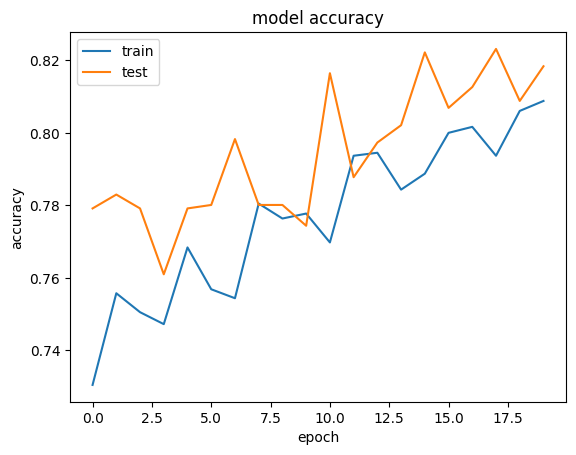

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

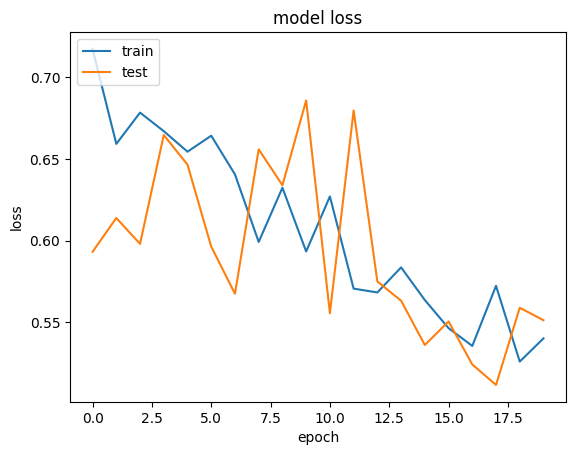

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Load the weights of the best model (assuming you have already saved them)
model.load_weights("/content/drive/MyDrive/drdo_weights.h5")  # Path of the file where the model is saved

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(val_data)

# Print the accuracy for the best model
print(f'Accuracy of the best model on the test dataset:  {test_accuracy * 100:.2f}%')


33/33 [==============================] - 3s 74ms/step - loss: 0.4794 - accuracy: 0.8432
Accuracy of the best model on the test dataset:  84.32%


In [ ]:
# Directory paths for train and test data
train_dir = train_dir
test_dir = test_dir

# Load the model
model = load_model('/content/drive/MyDrive/drdo_weights.h5')

# Define image data generators for test data
test_data_gen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Adjust to your image size
    batch_size=32,            # Adjust as needed
    class_mode='categorical',  # For classification
    shuffle=False              # Do not shuffle for evaluation
)

# Make predictions on the test data
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels (assuming one-hot encoding)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = test_generator.classes

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Calculate specificity (true negative rate)
'''tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
specificity = tn / (tn + fp)'''
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate specificity for each class
specificity = []
for i in range(cm.shape[0]):
    true_negative = sum(cm[j][j] for j in range(cm.shape[0])) - cm[i].sum()
    false_positive = cm[:, i].sum() - cm[i][i]
    specificity_i = true_negative / (true_negative + false_positive)
    specificity.append(specificity_i)

# Calculate the average specificity
average_specificity = np.mean(specificity)

# Print the results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Average Specificity: {average_specificity:.2f}')


Found 1046 images belonging to 5 classes.
33/33 [==============================] - 2s 73ms/step
Precision: 0.83
Recall: 0.83
F1 Score: 0.83
Average Specificity: 0.95


In [ ]:
# Calculate Cross-Entropy (Log Loss)
logloss = log_loss(true_labels, predictions)

# Calculate ROC AUC (Micro and Macro)
num_classes = 5  # We are having 5 classes
true_labels_bin = label_binarize(true_labels, classes=list(range(num_classes)))
roc_auc_micro = roc_auc_score(true_labels_bin, predictions, average='micro')
roc_auc_macro = roc_auc_score(true_labels_bin, predictions, average='macro')

# Calculate Mean Average Precision (mAP)
mAP = average_precision_score(true_labels_bin, predictions, average='micro')

# Calculate Cohen's Kappa
predicted_labels = np.argmax(predictions, axis=1)
kappa = cohen_kappa_score(true_labels, predicted_labels)

# Calculate Fowlkes-Mallows Index
fmi = fowlkes_mallows_score(true_labels, predicted_labels)

# Print the results
print(f'Cross-Entropy (Log Loss): {logloss:.4f}')
print(f'ROC AUC (Micro): {roc_auc_micro:.4f}')
print(f'ROC AUC (Macro): {roc_auc_macro:.4f}')
print(f'Mean Average Precision (mAP): {mAP:.4f}')
print(f'Cohen\'s Kappa: {kappa:.4f}')
print(f'Fowlkes-Mallows Index: {fmi:.4f}')


Cross-Entropy (Log Loss): 0.4794
ROC AUC (Micro): 0.9715
ROC AUC (Macro): 0.9676
Mean Average Precision (mAP): 0.9190
Cohen's Kappa: 0.7950
Fowlkes-Mallows Index: 0.7511


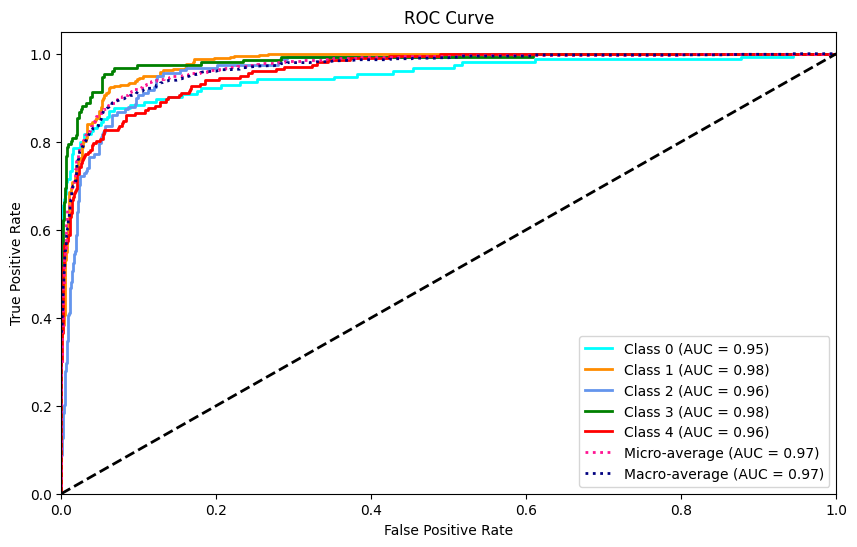

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

true_labels_bin = label_binarize(true_labels, classes=list(range(num_classes)))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_bin.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves for each class and the micro/macro averages
plt.figure(figsize=(10, 6))
lw = 2

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])  # Add more colors as needed

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', lw=lw,
         label='Micro-average (AUC = {0:0.2f})'.format(roc_auc["micro"]))
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle=':', lw=lw,
         label='Macro-average (AUC = {0:0.2f})'.format(roc_auc["macro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()



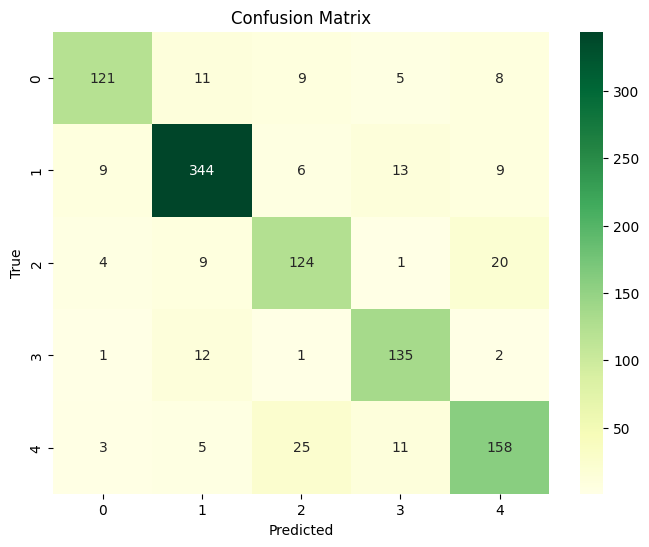

In [ ]:
# Plotting the Confusion matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGn')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Precision:
Precision in machine learning refers to the ability of a model to correctly classify positive instances (i.e., instances that belong to the class of interest) while minimizing the number of false positives (i.e., instances that are incorrectly classified as belonging to the class of interest).


## Accuracy:
Accuracy in deep learning refers to the ability of a model to correctly classify instances into their respective classes. In other words, accuracy is a measure of the overall correctness of a model's predictions.



## Cross Entropy:
The cross-entropy loss measures the average error between the model's predictions and the true labels.


## mAP:
Mean absolute precision in deep learning (MAP or mAP) is a metric used to evaluate the performance of object detection models. It is a measure of the average precision of a set of detections across different thresholds.



## cohen's kappa:
Cohen's kappa is a statistic that is used to measure the agreement between two raters on a categorical variable. It takes into account the possibility of the agreement occurring by chance, and it is generally thought to be a more robust measure than simple percent agreement calculation.

